# EDA

In [1]:
from datasets import load_dataset

corpus = load_dataset("castorini/mr-tydi-corpus", "indonesian", trust_remote_code=True)
mr_tydi = load_dataset("castorini/mr-tydi", "indonesian")
tydiqa_gold = load_dataset("khalidalt/tydiqa-goldp", 'indonesian', trust_remote_code=True)

print(corpus)
print(mr_tydi)
print(tydiqa_gold)

c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['docid', 'title', 'text'],
        num_rows: 1469399
    })
})
DatasetDict({
    train: Dataset({
        features: ['query_id', 'query', 'positive_passages', 'negative_passages'],
        num_rows: 4902
    })
    dev: Dataset({
        features: ['query_id', 'query', 'positive_passages', 'negative_passages'],
        num_rows: 1224
    })
    test: Dataset({
        features: ['query_id', 'query', 'positive_passages', 'negative_passages'],
        num_rows: 829
    })
})
DatasetDict({
    train: Dataset({
        features: ['id', 'language', 'document_title', 'passage_text', 'question_text', 'answers'],
        num_rows: 5702
    })
    validation: Dataset({
        features: ['id', 'language', 'document_title', 'passage_text', 'question_text', 'answers'],
        num_rows: 565
    })
})


Mengecek dataset mr_tydi, terutama terkait apakah:
1. semua positive_passages pada tiap row di ketiga split itu satu
2. kolom negative_passages itu ada isinya atau ngga

In [2]:
# Mengecek untuk split 'dev' dan 'test'
for split in mr_tydi:
    # Cek apakah semua positive_passages hanya berisi satu elemen
    all_positive_single = all(len(row['positive_passages']) == 1 for row in mr_tydi[split])
    
    # Cek apakah semua negative_passages kosong
    all_negative_empty = all(len(row['negative_passages']) == 0 for row in mr_tydi[split])

    print(f"Split: {split}")
    print(f"- Semua positive_passages berisi satu elemen: {all_positive_single}")
    if all_negative_empty:
        print('- Kolom negative passages kosong')
    else:
        print('- Kolom negative_passages ada isinya')
    print("-" * 50)

Split: train
- Semua positive_passages berisi satu elemen: True
- Kolom negative_passages ada isinya
--------------------------------------------------
Split: dev
- Semua positive_passages berisi satu elemen: True
- Kolom negative passages kosong
--------------------------------------------------
Split: test
- Semua positive_passages berisi satu elemen: False
- Kolom negative passages kosong
--------------------------------------------------


Karena kolom positive_passages pada split test tidak semuanya berjumlah satu, maka kita explore lebih dalam

In [3]:
from collections import Counter

# Hitung jumlah elemen dalam positive_passages untuk setiap row di split 'test'
positive_lengths = [len(row['positive_passages']) for row in mr_tydi['test']]

# Hitung distribusi jumlah elemen dalam positive_passages
length_counts = Counter(positive_lengths)

# Tampilkan hasil
print("Distribusi jumlah elemen dalam positive_passages pada split 'test':")
for length, count in sorted(length_counts.items()):
    print(f"- {count} row memiliki {length} elemen")

Distribusi jumlah elemen dalam positive_passages pada split 'test':
- 706 row memiliki 1 elemen
- 114 row memiliki 2 elemen
- 9 row memiliki 3 elemen


Melihat contoh baris yang jumlah positive_passages-nya lebih dari 1

In [4]:
from collections import defaultdict

# Buat dictionary untuk menyimpan contoh berdasarkan jumlah elemen positive_passages
examples_by_length = defaultdict(list)

# Loop melalui dataset test untuk mengumpulkan contoh
for row in mr_tydi['test']:
    length = len(row['positive_passages'])
    if len(examples_by_length[length]) < 2:  # Simpan maksimal 5 contoh per kategori
        examples_by_length[length].append(row)

# Tampilkan contoh
for length, examples in sorted(examples_by_length.items()):
    if length == 1:
        continue
    print(f"\n===== Contoh untuk positive_passages dengan {length} elemen =====")
    for i, example in enumerate(examples):
        print(f"\nContoh {i+1}:")
        print(f"Query: {example['query']}")
        print(f"Positive Passages: {example['positive_passages']}")


===== Contoh untuk positive_passages dengan 2 elemen =====

Contoh 1:
Query: Siapakah yang merumuskan naskah proklamasi ?
Positive Passages: [{'docid': '12126#13', 'text': '', 'title': ''}, {'docid': '12126#21', 'text': '', 'title': ''}]

Contoh 2:
Query: Apakah Learning Management System  memerlukan jaringan internet?
Positive Passages: [{'docid': '692014#3', 'text': '', 'title': ''}, {'docid': '692014#13', 'text': '', 'title': ''}]

===== Contoh untuk positive_passages dengan 3 elemen =====

Contoh 1:
Query: Apakah Perhimpunan Anak adalah nama sebuah organisasi ?
Positive Passages: [{'docid': '2620247#0', 'text': '', 'title': ''}, {'docid': '2620247#1', 'text': '', 'title': ''}, {'docid': '2620247#6', 'text': '', 'title': ''}]

Contoh 2:
Query: Kapan Kalium ditemukan ?
Positive Passages: [{'docid': '62199#1', 'text': '', 'title': ''}, {'docid': '62199#5', 'text': '', 'title': ''}, {'docid': '62199#21', 'text': '', 'title': ''}]


Memahami kolom negative_passages mr_tydi

In [14]:
# Periksa isi kolom positive_passages
negative_passages = mr_tydi['train'][0]['negative_passages']
print("jumlah negative passages dalam 1 row random:", len(negative_passages))
negative_passages[:5]

jumlah negative passages dalam 1 row random: 29


[{'docid': '7074#0',
  'text': 'dr. Tjipto Mangoenkoesoemo (EYD: Cipto Mangunkusumo) (Pecangaan, Jepara, Jawa Tengah, 1886 – Jakarta, 8 Maret 1943) adalah seorang tokoh pergerakan kemerdekaan Indonesia. Bersama dengan Ernest Douwes Dekker dan Ki Hajar Dewantara ia dikenal sebagai "Tiga Serangkai" yang banyak menyebarluaskan ide pemerintahan sendiri dan kritis terhadap pemerintahan penjajahan Hindia Belanda. Ia adalah tokoh dalam Indische Partij, suatu organisasi politik yang pertama kali mencetuskan ide pemerintahan sendiri di tangan penduduk setempat, bukan oleh Belanda. Pada tahun 1913 ia dan kedua rekannya diasingkan oleh pemerintah kolonial ke Belanda akibat tulisan dan aktivitas politiknya, dan baru kembali 1917.',
  'title': 'Tjipto Mangoenkoesoemo'},
 {'docid': '425142#0',
  'text': 'Olaf Douwes Dekker () adalah penyair dan wartawan Belanda. Kakek moyangnya yang ke-4, Jan, adalah saudara dari penulis Eduard Douwes Dekker, terkenal sebagai Multatuli. Wartawan, penulis, dan aktivi

Baris mr_tydi split train yang punya negative_passages terbanyak (30 - rerata emang segini) dan tersedikit (2 saja)

In [15]:
# Cari row dengan negative_passages terbanyak
split = mr_tydi['train']
max_neg_row = max(split, key=lambda row: len(row['negative_passages']))

# Tampilkan jumlah negative_passages terbanyak dan isi row tersebut
print(f"Jumlah negative_passages terbanyak: {len(max_neg_row['negative_passages'])}")
print("Row dengan negative_passages terbanyak:")
print(max_neg_row)
print()
# Kebalikannya: negative_passages tersedikit
min_neg_row = min(split, key=lambda row: len(row['negative_passages']))
print(f"Jumlah negative_passages tersedikit: {len(min_neg_row['negative_passages'])}")
print("Row dengan negative_passages tersedikit:")
print(min_neg_row)

Jumlah negative_passages terbanyak: 30
Row dengan negative_passages terbanyak:
{'query_id': '1', 'query': 'Siapa arsitek Balai Kota Seoul?', 'positive_passages': [{'docid': '2693620#5', 'text': 'Pada tanggal 18 Februari 2008, desain Yoo Kerl dari iArc terpilih dalam kompetisi desain Pemerintah Metropolitan Seoul.[6] Bagian atas depan bangunan baru ini dirancang untuk menonjol dalam bentuk lengkung. Perancang Yoo merangkul tiga kata kunci yakni "tradisi, warga negara, dan masa depan" dalam rancangannya, yang mencerminkan elemen horisontal dari arsitektur tradisional tingkat rendah Korea dan penafsiran ulang dari nuansa mendalam dan lekukan atap atap.[7]', 'title': 'Balai Kota Seoul'}], 'negative_passages': [{'docid': '2692513#0', 'text': 'Seoul Plaza adalah sebuah ruang terbuka umum yang berlokasi di depan Balai Kota Seoul di Taepyeongno, Jung-gu di Seoul, Korea Selatan. Plaza ini dibuka kembali pada 1 Mei 2004, oleh Pemerintah Metropolitan Seoul, dengan tujuan menyediakan ruang terbuka

rata-rata jumlah negative passages per baris

In [ ]:
# Tentukan split yang ingin diperiksa, misalnya 'train'
split = mr_tydi['train']

# Hitung total panjang negative_passages
total_negative_passages = sum(len(row['negative_passages']) for row in split)

# Hitung rata-rata
average_negative_passages = total_negative_passages / len(split)

# Cetak hasil
print(f"Rata-rata jumlah negative_passages: {average_negative_passages:.2f}")

Mengecek distribusi panjang jawaban (dihitung dalam jumlah kata) untuk dataset tydiqa_gold\[train\]

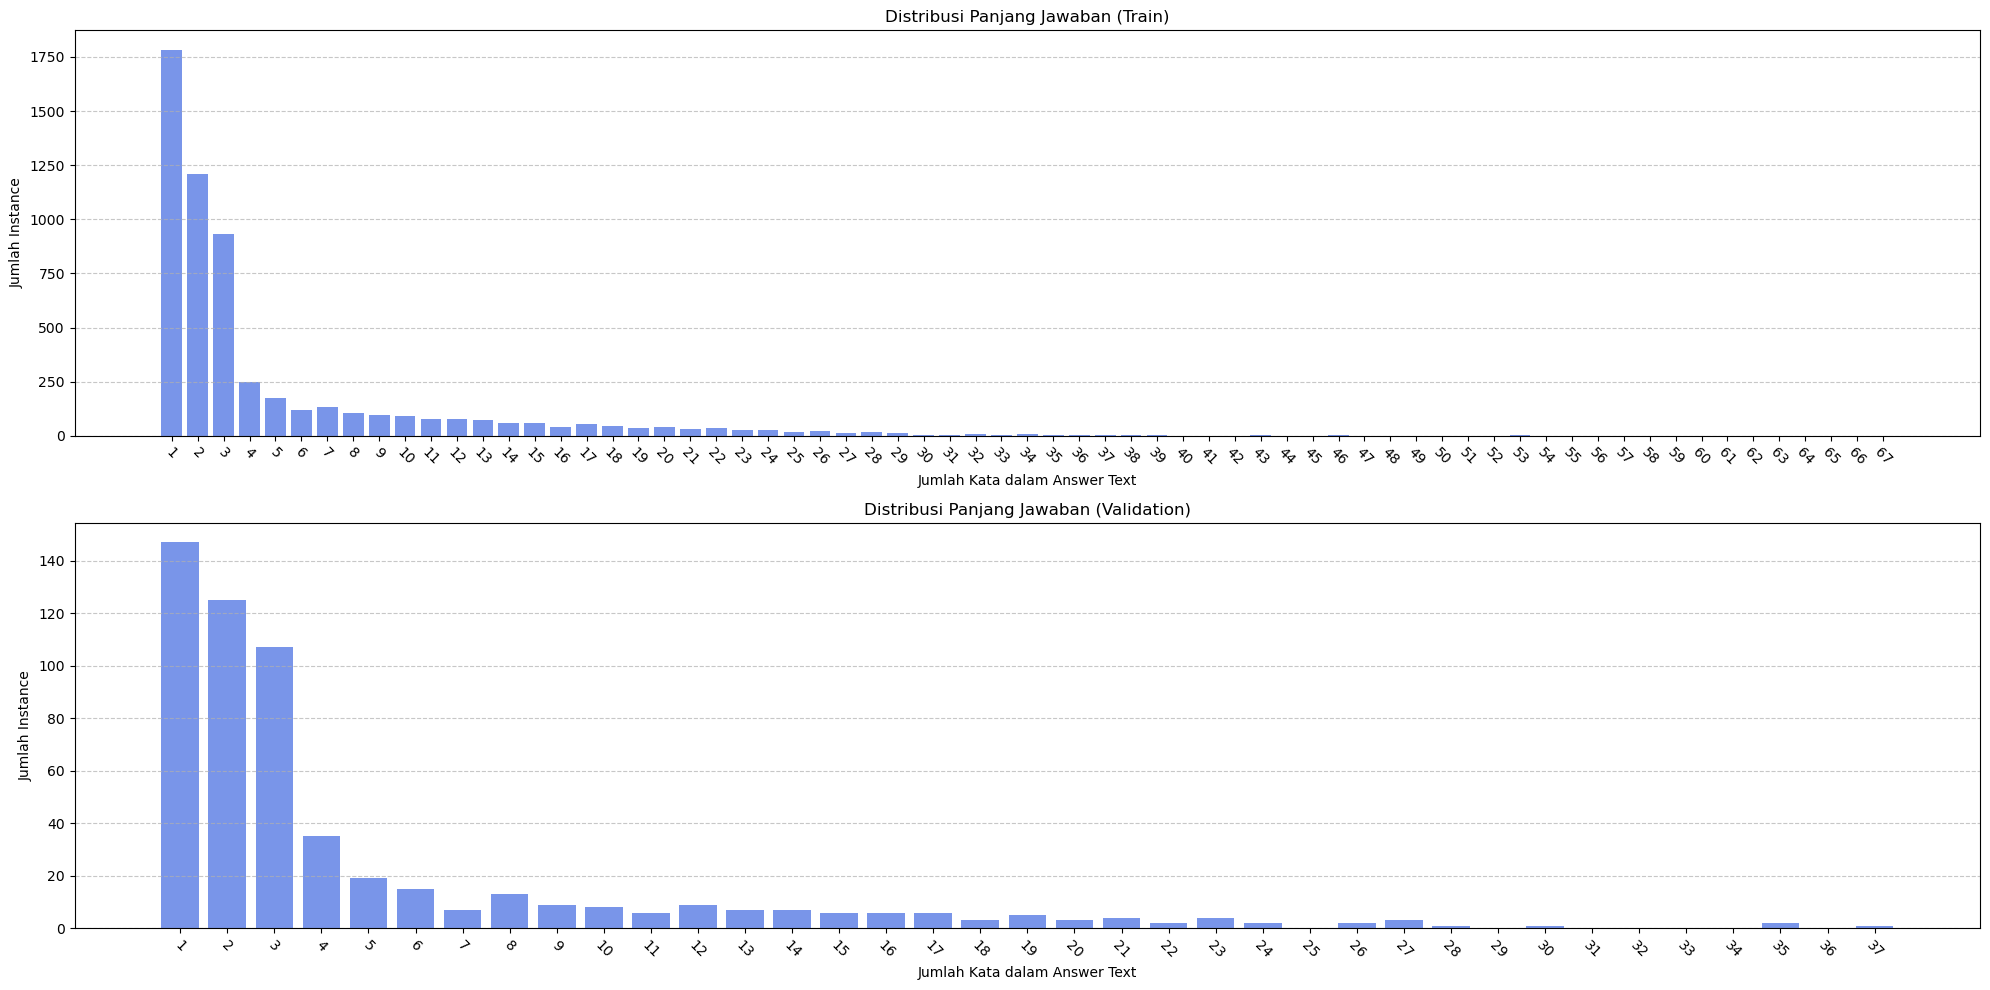

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

# Fungsi untuk menghitung distribusi panjang jawaban
def plot_length_distribution(dataset, ax, title):
    # Hitung distribusi panjang jawaban
    length_counts = Counter(len(row['answers']['text'][0].split()) for row in dataset if row['answers']['text'])
    
    # Urutkan berdasarkan panjang kata
    sorted_lengths = sorted(length_counts.items())
    
    # Ekstrak data untuk plotting
    lengths, counts = zip(*sorted_lengths)
    
    # Plot
    ax.bar(lengths, counts, color='royalblue', alpha=0.7)
    ax.set_xlabel("Jumlah Kata dalam Answer Text")
    ax.set_ylabel("Jumlah Instance")
    ax.set_title(title)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Sesuaikan xticks
    ax.set_xticks(range(min(lengths), max(lengths) + 1))  # Menampilkan semua jumlah kata pada sumbu x
    
    # Putar 315 derajat untuk ticks di sumbu X
    for tick in ax.get_xticklabels():
        tick.set_rotation(315)

# Membuat figure dengan 2 plot (satu di atas dan satu di bawah)
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharex=False)  # 2 baris, 1 kolom

# Plot untuk split 'train'
plot_length_distribution(tydiqa_gold['train'], axs[0], "Distribusi Panjang Jawaban (Train)")

# Plot untuk split 'validation'
plot_length_distribution(tydiqa_gold['validation'], axs[1], "Distribusi Panjang Jawaban (Validation)")

# Menampilkan plot
plt.tight_layout()  # Menyesuaikan layout agar tidak saling bertumpukan
plt.show()


In [8]:
# Filter instance yang panjang jawabannya adalah 10 kata
instances_10_words = [row for row in tydiqa_gold['train'] if len(row['answers']['text'][0].split()) == 10]

# Tampilkan beberapa contoh
print(f"Jumlah instance dengan jawaban 10 kata: {len(instances_10_words)}\n")

for i, example in enumerate(instances_10_words[:4]):  # Ambil 5 contoh pertama
    print(f"Contoh {i+1}:")
    print(f"Pertanyaan: {example['question_text']}")
    print(f"Jawaban: {example['answers']['text'][0]}")
    print(f"Konteks: {example['passage_text'][:200]}...")  # Hanya tampilkan sebagian konteks untuk ringkas
    print("-" * 80)


Jumlah instance dengan jawaban 10 kata: 91

Contoh 1:
Pertanyaan: Apakah yang dimaksud dengan Generasi Z?
Jawaban: orang-orang yang lahir dalam rentang tahun kelahiran 1995 sampai 2014
Konteks: Generasi Z adalah generasi setelah Generasi Y, yang didefenisikan sebagai orang-orang yang lahir dalam rentang tahun kelahiran 1995 sampai 2014[1]....
--------------------------------------------------------------------------------
Contoh 2:
Pertanyaan: Apa itu poliester ?
Jawaban: kategori polimer yang mengandung gugus fungsional ester dalam rantai utamanya
Konteks: 

Poliester adalah suatu kategori polimer yang mengandung gugus fungsional ester dalam rantai utamanya. Meski terdapat banyak sekali poliester, istilah "poliester" merupakan sebagai sebuah bahan yang ...
--------------------------------------------------------------------------------
Contoh 3:
Pertanyaan: Apakah peristiwa terbesar yang pernah terjadi di Pompeii ?
Jawaban: gempa bumi yang hebat yang menimbulkan kerusakan yang cukup b

In [ ]:
## Beberapa contoh row dimana jawaban ground truth lumayan panjang
long_answers_id = ['8223462044041100059-0', '8101241799056890701-0', '-1836421090681989358-7']

Melihat jumlah kemunculan kata pertama (kata tanya) unik

In [6]:
from collections import Counter
import pandas as pd
# Ambil kolom 'question_text' dari dataset train
questions = tydiqa_gold['train']['question_text']

# Ambil kata pertama dari setiap pertanyaan
first_words = [question.lower().split()[0] if question.strip() else None for question in questions]

# Hitung jumlah kemunculan tiap kata pertama
first_word_counts = Counter(first_words)

# Konversi hasil ke DataFrame untuk tampilan lebih mudah
first_word_df = pd.DataFrame(first_word_counts.items(), columns=["First Word", "Count"]).sort_values(by="Count", ascending=False)

# Tampilkan hasil
first_word_df.head(10)

,First Word,Count
5,apakah,953
2,kapan,919
6,apa,851
4,siapakah,528
7,berapakah,406
8,berapa,391
1,siapa,379
3,dimana,255
0,dimanakah,245
9,kapankah,238
